In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

In [2]:
import pandas as pd 
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import fftpack
import pylab
import seaborn as sns
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from pylab import rcParams
rcParams['figure.figsize'] = 22, 7
sns.set()

In [3]:
df  = pd.read_csv('./data/AEP_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


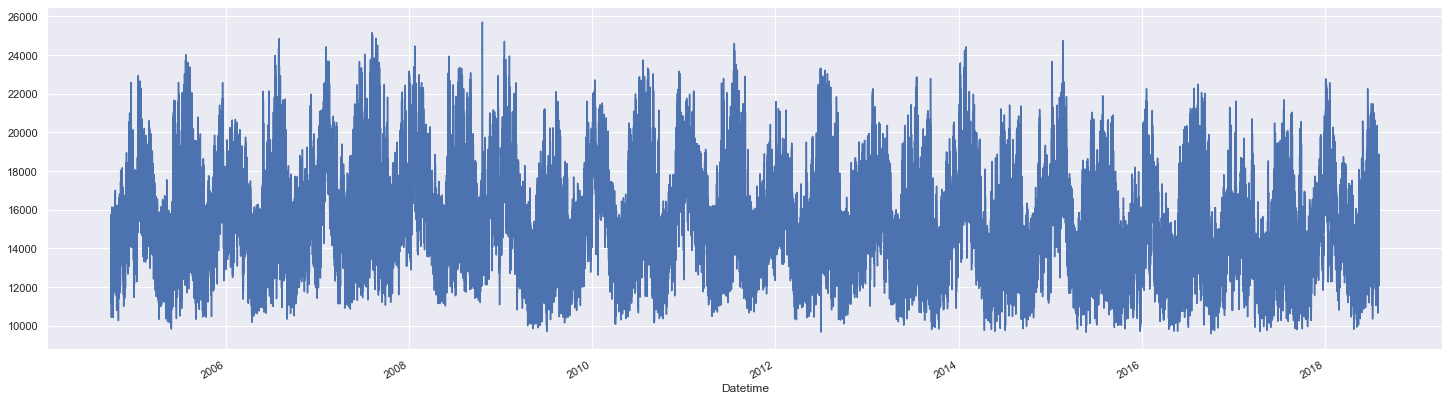

In [4]:
df['AEP_MW'].plot(figsize=(25,7));

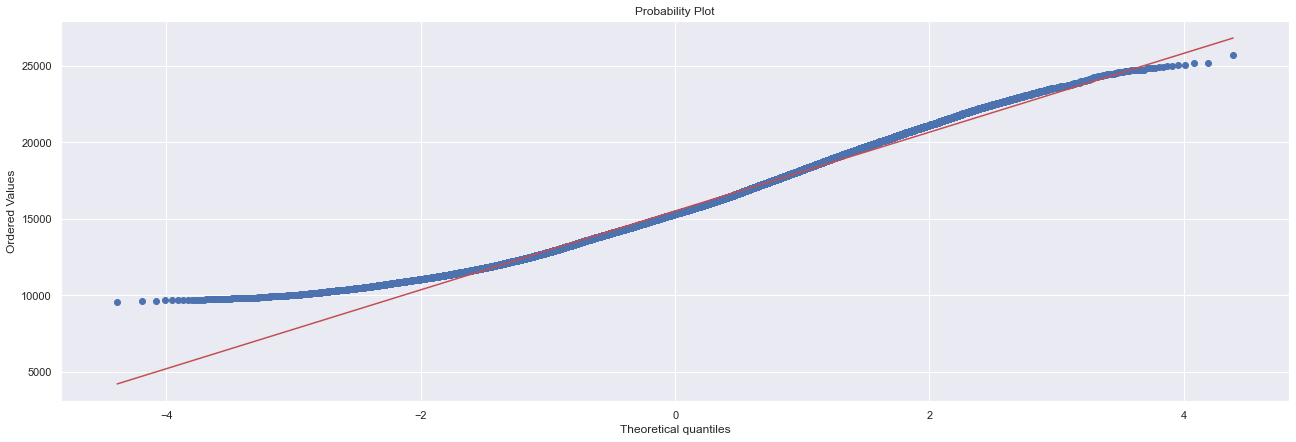

In [5]:
scipy.stats.probplot(df['AEP_MW'], plot=pylab);

In [ ]:
df

In [ ]:
# Fourier transformation to center the data aroud the mean
fft = fftpack.fft(df['AEP_MW'].values - df['AEP_MW'].values.mean())
fft

In [ ]:
np.arange(4)

In [ ]:
len(fft)/(len(df)/(365*24))

In [ ]:
print(len(fft), len(df))

In [ ]:
plt.plot(np.arange(len(fft))/(len(df)/(365*24)), abs(fft)) 
#plt.xlim(0,4)
plt.xlabel('frequency 1/yr')
plt.title('Fourier Transform of the original time series')
plt.show()

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class FourierComponents(BaseEstimator, TransformerMixin):
    def __init__(self, freqs):
        """Create features based on sin(2*pi*f*t) and cos(2*pi*f*t)."""
        self.freqs = freqs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xt = np.zeros((X.shape[0], 2*len(self.freqs)))
        
        for i, f in enumerate(self.freqs):

            Xt[:, 2*i]= np.cos(2*np.pi*f*X).reshape(-1)
            Xt[:, 2*i + 1] = np.sin(2*np.pi*f*X).reshape(-1)
    
        return Xt

In [ ]:
#Annual and Bi-annual and daily frequency components Frequencies
fourier= FourierComponents([1/(365*24), 1/(2*365*24), 1/(260*24)])
pipe = Pipeline([
    ('fourier', fourier),
    ('lr', GridSearchCV(Ridge(), param_grid={'alpha': np.logspace(-2,2,10)}, cv=TimeSeriesSplit(5)))
])

In [ ]:
fourier.fit_transform(df.values)

In [ ]:
pipe.fit(df.values, df['AEP_MW'])

In [ ]:
pred = pd.DataFrame(pipe.predict(df.values), index = df.index, columns=['predictions'])
pred.head()

In [ ]:
plt.plot(df['AEP_MW'][-20:])
pred.predictions[-20:].plot();

In [ ]:
pipe.score(df.values, df['AEP_MW'])

In [ ]:
pipe.named_steps['lr'].best_params_

## Phase 2 -- Comparision

In [7]:
df.info(), df.index.max(), df.index.min(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


(None,
 Timestamp('2018-08-03 00:00:00'),
 Timestamp('2004-10-01 01:00:00'),
 AEP_MW    0
 dtype: int64)

In [8]:
size = int(len(df)*0.8)
len(df), size

(121273, 97018)

In [9]:
df_train = df.iloc[:size]
df_train.shape, df_train.index.min(), df_train.index.max()

((97018, 1),
 Timestamp('2004-10-01 01:00:00'),
 Timestamp('2016-01-01 00:00:00'))

In [10]:
df_test = df.iloc[size:]
df_test.shape, df_test.index.min(), df_test.index.max()

((24255, 1),
 Timestamp('2015-01-01 01:00:00'),
 Timestamp('2018-08-03 00:00:00'))

In [11]:
fft = fftpack.fft(df_train['AEP_MW'].values - df_train['AEP_MW'].values.mean())
fourier= FourierComponents([1/(365*24), 1/(2*365*24), 1/(260*24)])
pipe = Pipeline([
    ('fourier', fourier),
    ('lr', GridSearchCV(Ridge(), param_grid={'alpha': np.logspace(-2,2,10)}, cv=TimeSeriesSplit(5)))
])
fourier.fit_transform(df_train.values)
pipe.fit(df_train.values, df_train['AEP_MW'])

Pipeline(steps=[('fourier',
                 FourierComponents(freqs=[0.00011415525114155251,
                                          5.7077625570776254e-05,
                                          0.00016025641025641026])),
                ('lr',
                 GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                              estimator=Ridge(),
                              param_grid={'alpha': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])}))])

In [12]:
pred = pd.DataFrame(pipe.predict(df_test.values), index = df_test.index, columns=['predictions'])
pred.head()

,predictions
Datetime,
2015-03-07 09:00:00,18405.569896
2015-03-07 10:00:00,17859.490217
2015-03-07 11:00:00,17220.547815
2015-03-07 12:00:00,16407.861152
2015-03-07 13:00:00,15727.629536


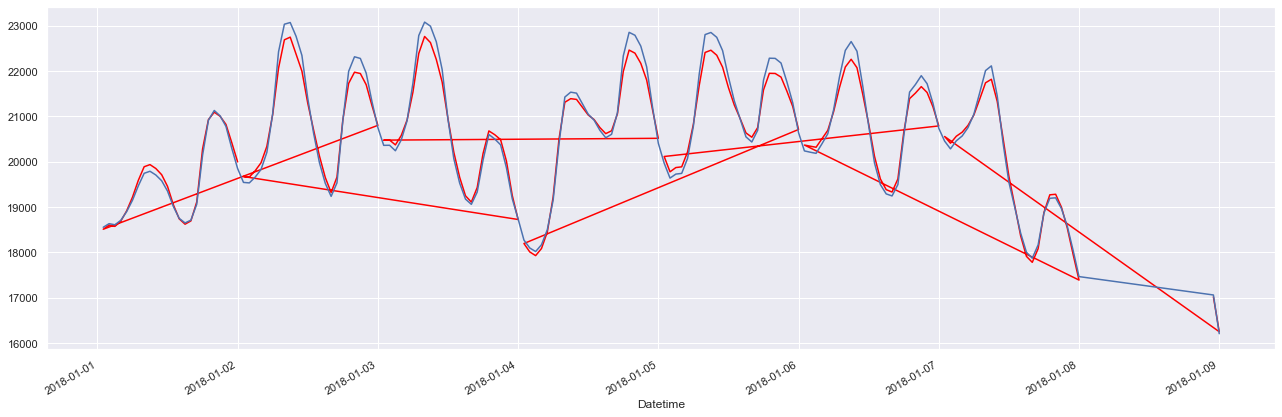

In [13]:
plt.plot(df_test['AEP_MW'][-170:], color='red')
pred.predictions[-170:].plot();

In [14]:
pipe.score(df_test.values, df_test['AEP_MW'])

0.9962298517918129

## Applying ARIMA

In [17]:
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
adfuller(df_train) #data is not stationary

(-14.459391395640356,
 6.88735947564505e-27,
 67,
 96950,
 {'1%': -3.4304174520180424,
  '5%': -2.861569812724871,
  '10%': -2.566785868272034},
 1395309.5676660624)

In [24]:
df_train.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2015-03-08 23:00:00', '2015-03-09 00:00:00',
               '2015-03-07 01:00:00', '2015-03-07 02:00:00',
               '2015-03-07 03:00:00', '2015-03-07 04:00:00',
               '2015-03-07 05:00:00', '2015-03-07 06:00:00',
               '2015-03-07 07:00:00', '2015-03-07 08:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=97018, freq=None)

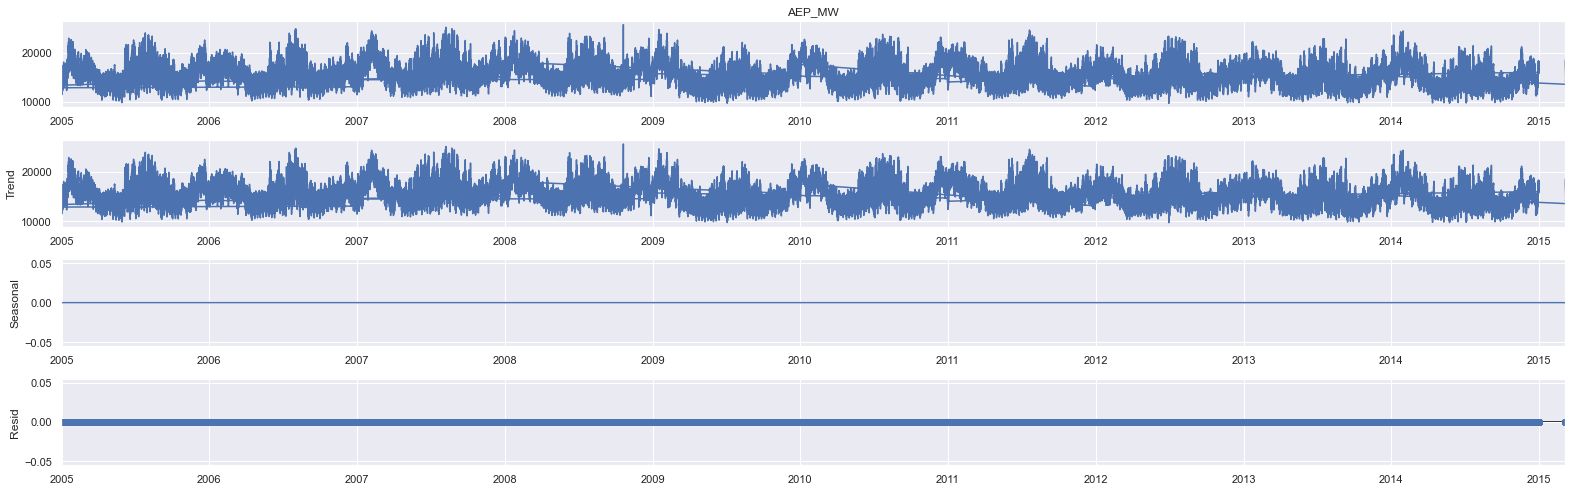

In [31]:
seasonal_decompose(df_train.AEP_MW, period=(2004-10-1 < 2016-10-1), model='additive').plot();

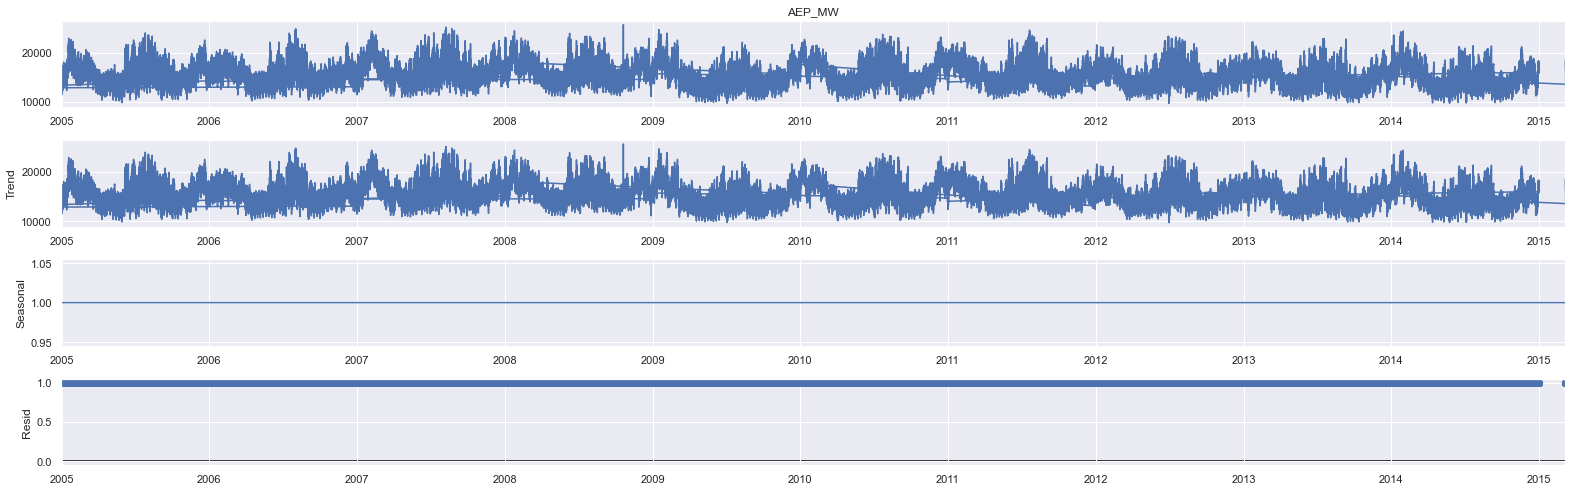

In [30]:
seasonal_decompose(df_train.AEP_MW, period=(2004-10-1 < 2016-10-1), model='multiplicative').plot();

In [ ]:
seasonal_decompose(df.market_value, model='additive').plot();

In [57]:
df_train['AEP_MW'].iloc[:size]

Datetime
2004-12-31 01:00:00    13478.0
2004-12-31 02:00:00    12865.0
2004-12-31 03:00:00    12577.0
2004-12-31 04:00:00    12517.0
2004-12-31 05:00:00    12670.0
                        ...   
2015-03-07 04:00:00    17331.0
2015-03-07 05:00:00    17484.0
2015-03-07 06:00:00    17855.0
2015-03-07 07:00:00    18292.0
2015-03-07 08:00:00    18497.0
Name: AEP_MW, Length: 97018, dtype: float64

In [58]:
model_auto = auto_arima(df_train['AEP_MW'], max_p=15, max_q=15, max_P=15, max_Q=15, trend="ct")

In [59]:
model_auto.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                97018
Model:               SARIMAX(8, 1, 0)   Log Likelihood             -736802.152
Date:                Tue, 31 Aug 2021   AIC                        1473626.303
Time:                        10:02:30   BIC                        1473730.612
Sample:                             0   HQIC                       1473658.002
                              - 97018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      3.157      0.001      1.000      -6.185       6.189
drift       4.561e-07   5.59e-05      0.008      0.993      -0.000       0.000
ar.L1          0.5793      0.001    474.453      0.000       0.577       0.582
ar.L2          0.0392      0.003     13.948      0.000       0.034       0.045
ar.L3         -0.0255      0.005     -5.219      0.000      -0.035      -0.016
ar.L4          0.0025      0.005      0.487      0.626      -0.008       0.013
ar.L5         -0.0496      0.004    -11.848      0.000      -0.058      -0.041
ar.L6         -0.0629      0.003    -19.502      0.000      -0.069      -0.057
ar.L7         -0.0784      0.004    -20.910      0.000      -0.086      -0.071
ar.L8         -0.0545      0.003    -15.773      0.000      -0.061      -0.048
sigma2      2.312e+05    371.620    622.120      0.000     2.3e+05    2.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2004318.85
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
start_date = df_test.index.min()
end_date = df_test.index.max()
start_date, end_date

(Timestamp('2015-01-01 01:00:00'), Timestamp('2018-08-03 00:00:00'))

In [62]:
predictions = model_auto.predict(n_periods= len(df_test))
predictions = pd.DataFrame(predictions, index=df_test.index, columns=['AEP_MW'])
predictions

,AEP_MW
Datetime,
2015-03-07 09:00:00,18445.052121
2015-03-07 10:00:00,18410.534282
2015-03-07 11:00:00,18354.210656
2015-03-07 12:00:00,18260.233265
2015-03-07 13:00:00,18129.255389
...,...
2018-01-01 20:00:00,19889.276284
2018-01-01 21:00:00,19889.364137
2018-01-01 22:00:00,19889.451992


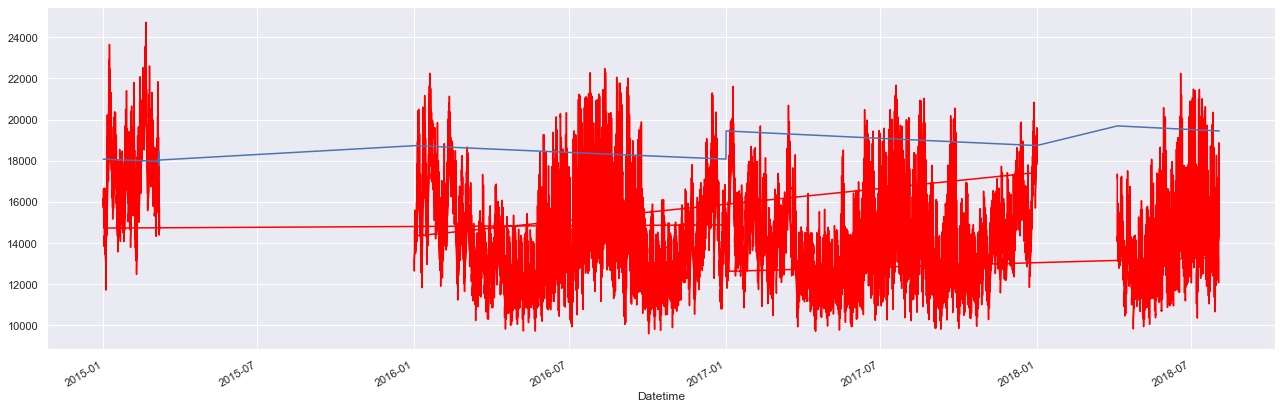

In [65]:
plt.plot(df_test['AEP_MW'][:-2270], color='red')
predictions['AEP_MW'][:-2270].plot();

## Conclusion

`Fourier Series` has to have some features, otherwise it cannot only word with target column